In [1]:
import pandas as pd
from pandas import DataFrame
import requests
import os
import os.path
import datetime as dt
import json
import numpy as np
from datetime import timedelta, datetime
from dateutil import parser
import math
%matplotlib inline
from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings('ignore')

In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
# Load environment variables 
binance_api_key = os.getenv("BINANCE_API_KEY")
binance_secret_key= os.getenv("BINANCE_SECRET_KEY")



In [3]:
type(binance_api_key)

str

In [4]:
## Set up client 
from binance.client import Client
binance_client = Client(api_key=binance_api_key, api_secret=binance_secret_key)

# Constants
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

# Create collecting new data function
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2015', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Create function to retreive tickers and timestamps
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2015', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [5]:
symbols = ['LINKBTC', 'VETBTC', 'WTCBTC']

In [6]:
# Get vechain data
vet_data=get_all_binance('VETBTC', '1h')
vet_data.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2018-07-25 04:00:00,0.00000300,0.00000300,0.00000242,0.00000262,313149726.00000000,1532494799999,817.87571825,6804,166006854.00000000,436.76017934,0
2018-07-25 05:00:00,0.00000258,0.00000264,0.00000253,0.00000262,53266947.00000000,1532498399999,137.65478612,2235,30317135.00000000,78.49932764,0
2018-07-25 06:00:00,0.00000262,0.00000266,0.00000255,0.00000256,51329133.00000000,1532501999999,133.21059982,2367,27149823.00000000,70.62251135,0
2018-07-25 07:00:00,0.00000256,0.00000260,0.00000252,0.00000258,27692582.00000000,1532505599999,71.03679491,2229,14584941.00000000,37.51642375,0
2018-07-25 08:00:00,0.00000258,0.00000260,0.00000251,0.00000254,30060366.00000000,1532509199999,76.68867857,2986,11313789.00000000,29.05391403,0


In [7]:
vet_data=vet_data.loc[:,['high', 'low', 'close']]

In [8]:
vet_data=vet_data.apply(pd.to_numeric)

In [9]:
vet_data = vet_data.loc['2020-06-11 01:00:00':'2020-07-11 01:00:00']

In [10]:
# Calculate the difference in closing prices day over day
vet_data['delta'] = vet_data['close'].diff()
vet_data = vet_data.dropna()

In [11]:
# Make the positive gains (up) and negative gains (down) Series
up, down = vet_data['delta'].copy(), vet_data['delta'].copy()
up[up < 0] = 0
down[down > 0] = 0

In [13]:
window_length = 14

In [14]:
# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
vet_data['RSI1'] = 100.0 - (100.0 / (1.0 + RS1))

In [15]:
short_window = 7
long_window = 14

In [17]:
# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
vet_data['fast_close'] = vet_data['close'].ewm(halflife=short_window).mean()
vet_data['slow_close'] = vet_data['close'].ewm(halflife=long_window).mean()

In [18]:
vet_data.tail()

,high,low,close,delta,RSI1,fast_close,slow_close
timestamp,,,,,,,
2020-07-10 21:00:00,0.000002,0.000002,0.000002,-7.000000e-08,49.618048,0.000002,0.000002
2020-07-10 22:00:00,0.000002,0.000002,0.000002,-1.000000e-08,47.937829,0.000002,0.000002
2020-07-10 23:00:00,0.000002,0.000002,0.000002,2.000000e-08,51.711369,0.000002,0.000002
2020-07-11 00:00:00,0.000002,0.000002,0.000002,0.000000e+00,51.711369,0.000002,0.000002
2020-07-11 01:00:00,0.000002,0.000002,0.000002,-1.000000e-08,49.331167,0.000002,0.000002


Text(0.5, 1.0, 'MACD')

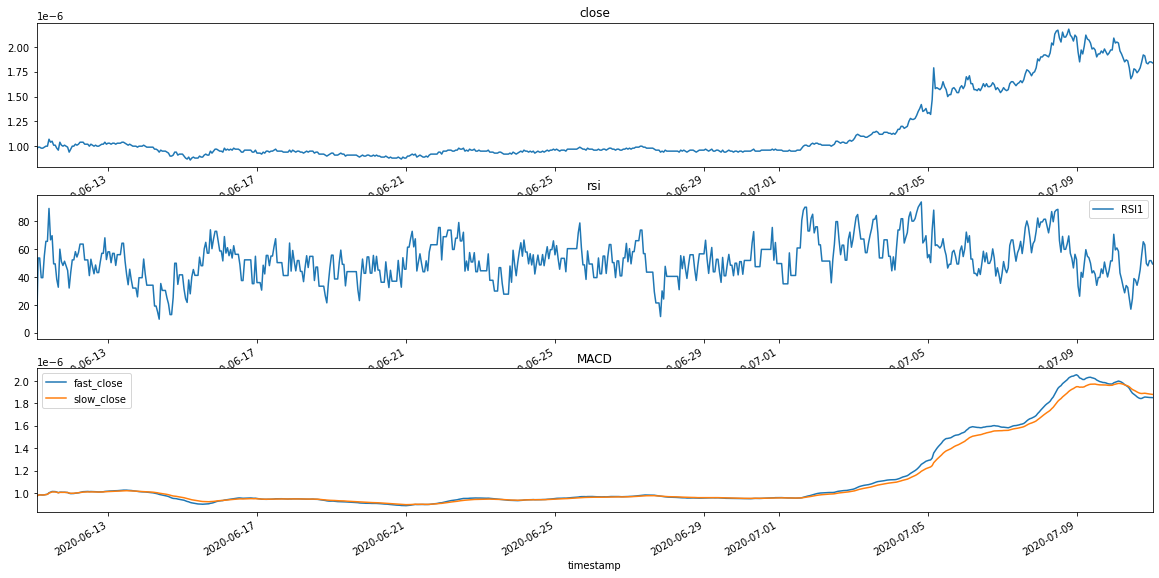

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,10))
vet_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
vet_data[['RSI1']].plot(ax=axes[1]); axes[1].set_title('rsi')
vet_data[['fast_close', 'slow_close']].plot(ax=axes[2]); axes[2].set_title('MACD')

In [20]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the shorter-term ma, (fast-close) crosses below the slow-close line, it provides a bearish sell signal.
vet_data['Sell Entry'] = ((vet_data['fast_close'] < vet_data['slow_close']) & (vet_data['RSI1'] > 70)) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the slow close line crosses back up through the fast-close line 
vet_data['Sell Exit'] = ((vet_data['fast_close'] > vet_data['slow_close']))
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
vet_data['Short'] = np.nan 
vet_data.loc[vet_data['Sell Entry'],'Short'] = -1 
vet_data.loc[vet_data['Sell Exit'],'Short'] = 0 
#Set initial position on day 1 to flat 
vet_data['Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
vet_data['Short'] = vet_data['Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the shorter-term ma, (fast-close) the more reactive line crosses above the slower line (slow-close) and the RSI is below 30 
vet_data['Buy Entry'] = ((vet_data['fast_close'] > vet_data['slow_close']) & (vet_data['RSI1'] < 30)) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the slow close line crosses back up below the fast-close line 
vet_data['Buy Exit'] = (vet_data['fast_close'] < vet_data['slow_close'])
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
vet_data['Long'] = np.nan  
vet_data.loc[vet_data['Buy Entry'],'Long'] = 1  
vet_data.loc[vet_data['Buy Exit'],'Long'] = 0  
#Set initial position on day 1 to flat 
vet_data['Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
vet_data['Long'] = vet_data['Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
vet_data['Position'] = vet_data['Long'] + vet_data['Short']


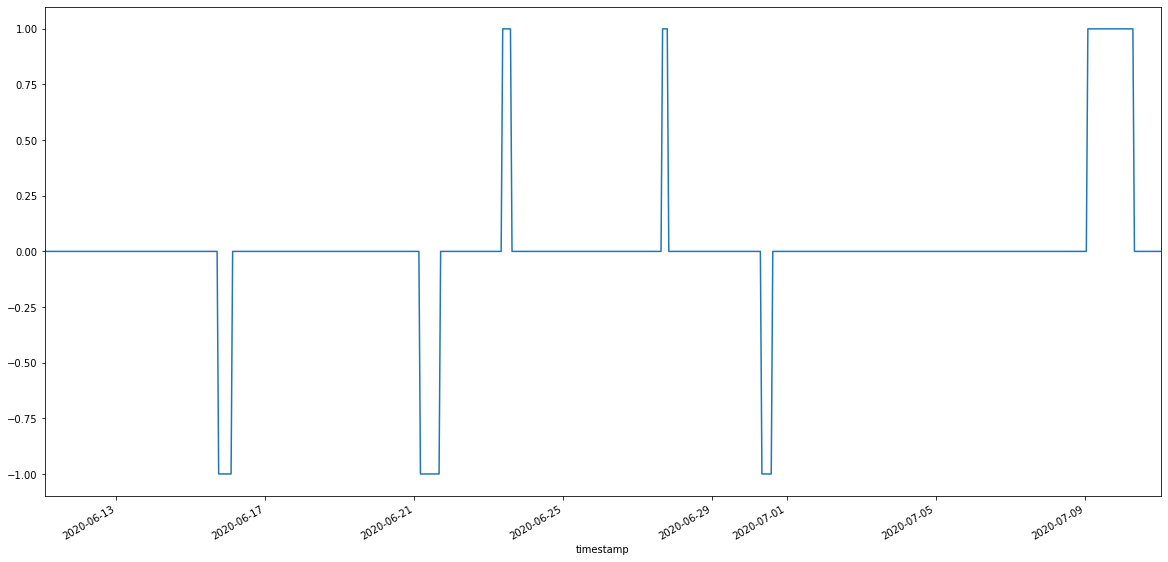

In [21]:
vet_data['Position'].plot(figsize=(20,10))

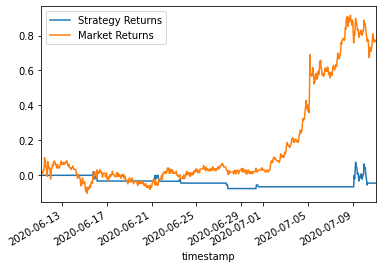

In [22]:
#Set up a column holding the daily vechain returns
vet_data['Market Returns'] = vet_data['close'].pct_change()
#Create column for Strategy Returns by multiplying the daily vechain returns by the position that was held at close
#of business the previous day
vet_data['Strategy Returns'] = vet_data['Market Returns'] * vet_data['Position'].shift(1)
#Finally plot the strategy returns versus VET returns
vet_data[['Strategy Returns','Market Returns']].cumsum().plot()